## Import modułów
Najważniejsze moduły wykorzystywane w projekcie:
* **numpy, pandas** - gromadzenie i porządkowanie danych
* **matplotlib.pyplot** - wizualizacja danych
* **sklearn (z pakietu scikit-learn)** - rozbudowane narzędzie do m.in *machine learningu*

In [1]:
import warnings
from typing import List
import pandas as pd
import spacy
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

<hr style="border-top: 2px dashed white">

## Praca z danymi

#### Wczytanie danych

In [3]:
movies = pd.read_csv('movies-processed.csv', sep='*', keep_default_na=False)
movies

,title,overview,imdb_id,popularity,overview_punctuationless
0,Hyper Sapien: People from Another Star,Three aliens from the planet Taros land on Ear...,tt0091238,0.000009,three alien from the planet taros land on eart...
1,Chameli Ki Shaadi,"Charandas, a young man in a village has no aim...",tt0090812,0.000009,charandas a young man in a village have no aim...
2,Blade Runner,In the smog-choked dystopian Los Angeles of 20...,tt0083658,96.272374,in the smog choke dystopian los angeles of 201...
3,Dinosaur,An orphaned dinosaur raised by lemurs joins an...,tt0130623,9.998415,an orphan dinosaur raise by lemur join an ardu...
4,Jarhead,Jarhead is a film about a US Marine Anthony Sw...,tt0418763,9.997032,jarhead be a film about a us marine anthony sw...
...,...,...,...,...,...
44456,Pleasure Party,Phillipe and Esther live an apparently idyllic...,tt0072342,0.000000,phillipe and esther live an apparently idyllic...
44457,Vogelfrei,Four directors tell the story of a single man ...,tt1048173,0.000000,four director tell the story of a single man a...
44458,Enola Gay and the Atomic Bombing of Japan,American Documentary,tt0185048,0.000000,american documentary
44459,Monk by Blood,One young Japanese man struggles with his dest...,tt3631388,0.000000,one young japanese man struggle with his desti...


In [4]:
movies_cosine = pd.read_pickle('cosine-similarity.pickle')
movies_cosine.iloc[:3, :3]

,Hyper Sapien: People from Another Star,Chameli Ki Shaadi,Blade Runner
Hyper Sapien: People from Another Star,1.00000,0.000000,0.034840
Chameli Ki Shaadi,0.00000,1.000000,0.004997
Blade Runner,0.03484,0.004997,1.000000


<hr style="border-top: 2px dashed white">

## Funkcje do wykorzystania aplikacji

#### Funkcja do wyszukiwania podobnych filmów

In [5]:
def find_similar(title: str) -> dict:
    try:
        similiarities = movies_cosine.loc[title]
    except KeyError as e:
        print(f'Nie znaleziono filmu: {e}.')
        return None
    
    # Case if more than 1 movie with the same title
    if isinstance(similiarities, pd.core.frame.DataFrame):
        similiarities = similiarities.iloc[0]  
         
    top_similar = similiarities.sort_values(ascending=False)
    top10_similar = dict(top_similar[1:11].items())
    return top10_similar

#### Funkcja, która sugeruje podobne tytuły, jeżeli input użytkownika nie zostanie odnaleziony

In [6]:
def suggest_titles(title: str) -> None:
    nlp = spacy.load('en_core_web_md', disable=["ner", "parser"])
    title_nlp = nlp(title.lower())
    similarities = []
    for _, row in movies.iterrows():
        if not isinstance(row['title'], str):
            continue
        
        compared_title = nlp(row['title'].lower())
        similarity = title_nlp.similarity(compared_title)
        similarities.append((row['title'], similarity))
        
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[:10]
    similarities_titles_only = list(map(lambda x: x[0], similarities))
    suggestions_df = pd.DataFrame(data=similarities_titles_only, columns=['Title'])
    suggestions_df.index = suggestions_df.index + 1

    print('Być może miał(aś/eś) na myśli:')
    print(suggestions_df)

#### Funkcja do prezentacji wyników

In [7]:
def create_chart(matches: dict, title: str, savetofile: bool=False):
    matches = dict(sorted(matches.items(), key=lambda item: item[1]))
    plt.style.use('seaborn-v0_8')
    fig, ax = plt.subplots()
    
    for movie, similarity in matches.items():
        rects = ax.barh(movie, np.round(similarity*100, 2))
        ax.bar_label(rects, padding=2)

    ax.set_title(f'Najlepsze dopasowania dla filmu {title}')
    ax.set_xlabel('Zgodność opisów (%)')
    ax.set_ylabel('Znalezione filmy')

    plt.show()

    if savetofile:
        title_no_spaces = title.replace(' ', '_')
        fig.savefig(f'{title_no_spaces}_matches.jpg', bbox_inches='tight', dpi=300)

<hr style="border-top: 2px dashed white">

## Rezultat

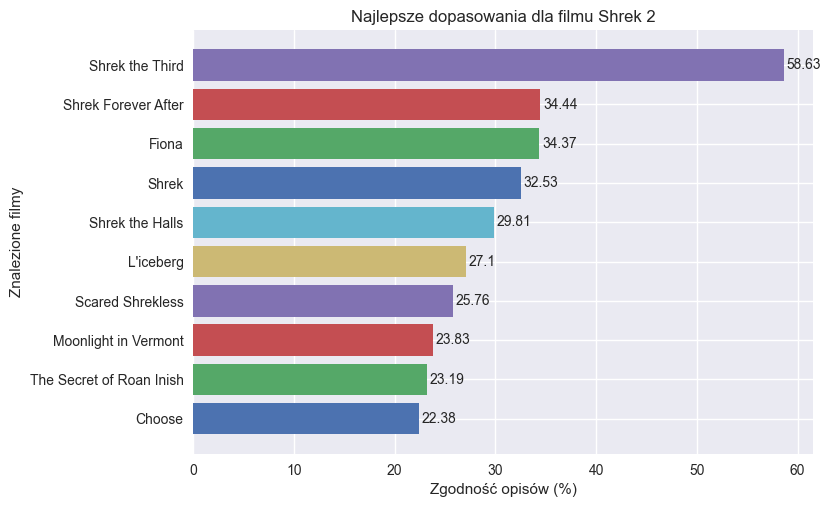

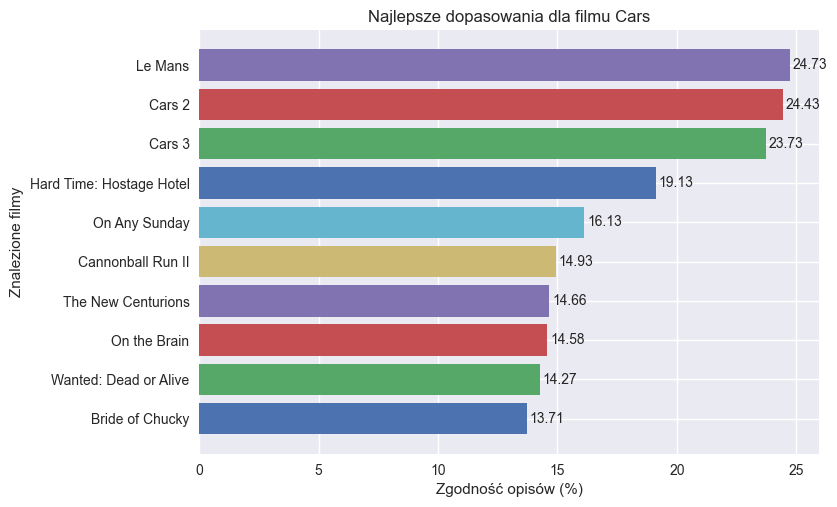

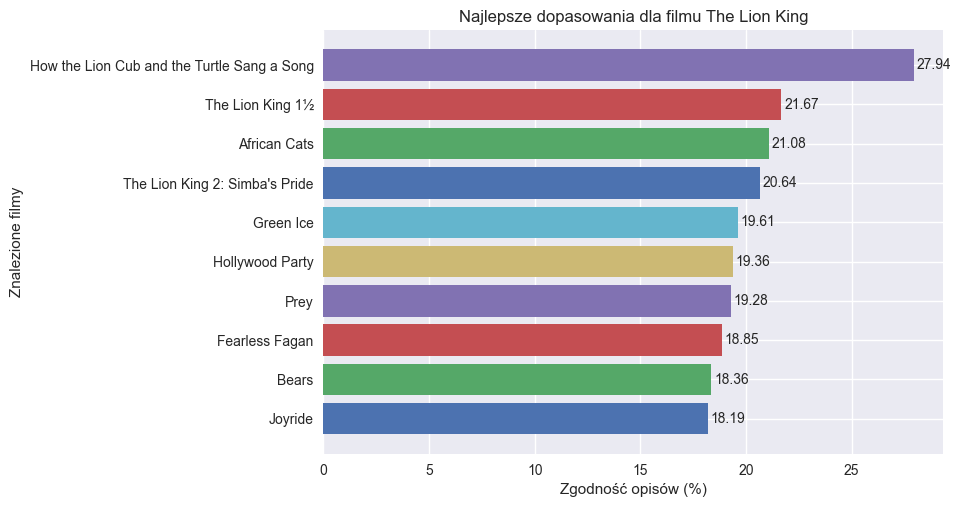

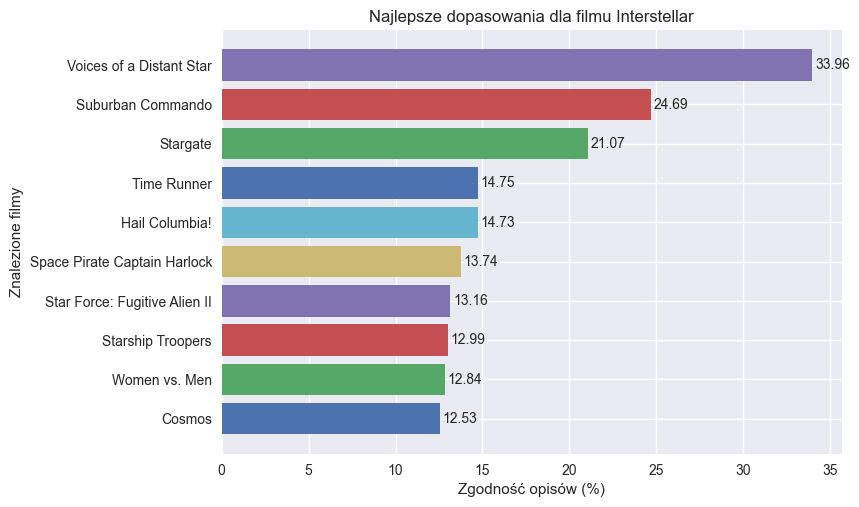

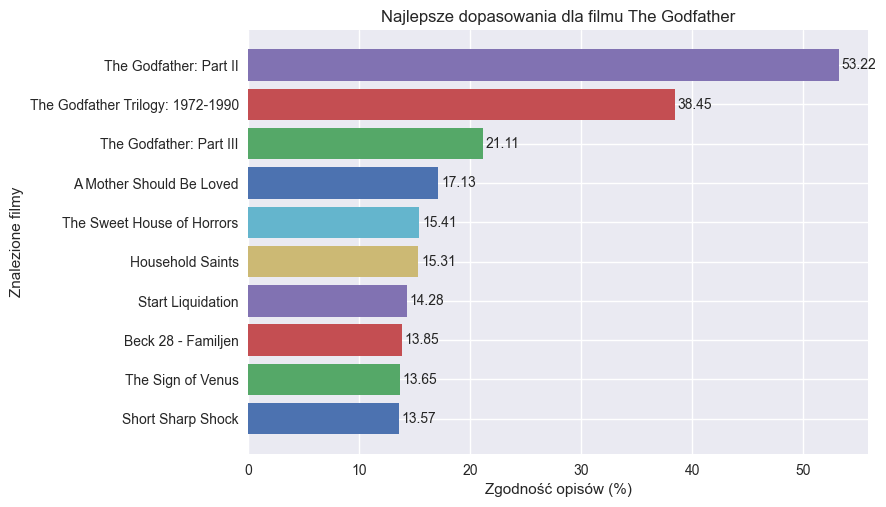

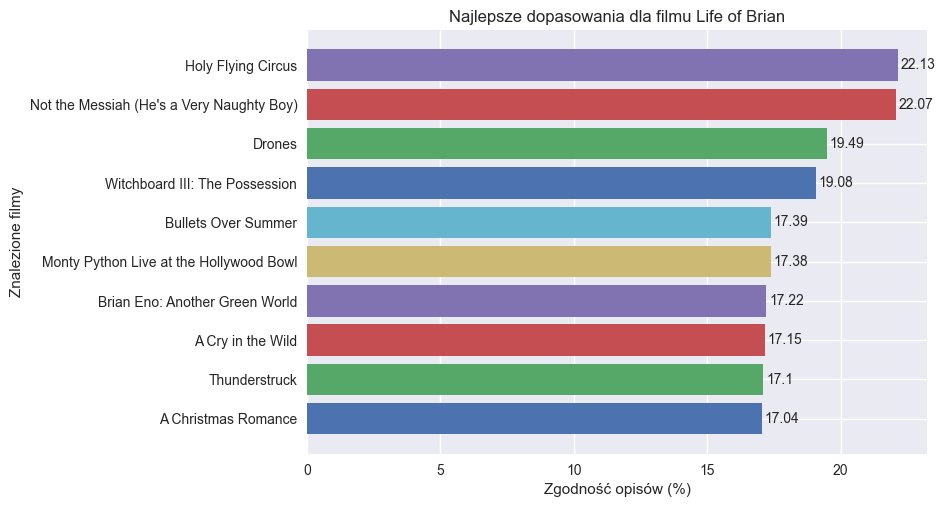

Nie znaleziono filmu: 'Lord of the Drinks'.
Być może miał(aś/eś) na myśli:
                      Title
1     The Lords of Flatbush
2         Lord of the Flies
3         Lord of the Flies
4   The Lords of Discipline
5     The Lord of the Rings
6      King of the Belgians
7         Edges of the Lord
8    The Kingdom of Fairies
9      The Kings of Mykonos
10   The Mistress of Spices


In [8]:
example_titles = (
    'Shrek 2', 'Cars', 'The Lion King', 'Interstellar', 'The Godfather', 'Life of Brian', 'Lord of the Drinks'
)
for title in example_titles:
    top_matches = find_similar(title=title)
    if top_matches:
        create_chart(matches=top_matches, title=title, savetofile=True)
    else:
        suggest_titles(title=title)

<hr style="border-top: 2px dashed white">

## Dodatkowo:

#### WordCloud

In [9]:
def tokenize(text: str) -> str:
    tokens = []
    doc = nlp(text)
    tokens = [
        token.lemma_
        for token in doc
        if token.text not in STOPWORDS and token.text.isalpha()
    ]

    return " ".join(tokens)

movies["tokens"] = movies["overview"].apply(tokenize)
overviews = movies.tokens.values.flatten()
overviews_str = ' '.join(overviews)

NameError: name 'nlp' is not defined

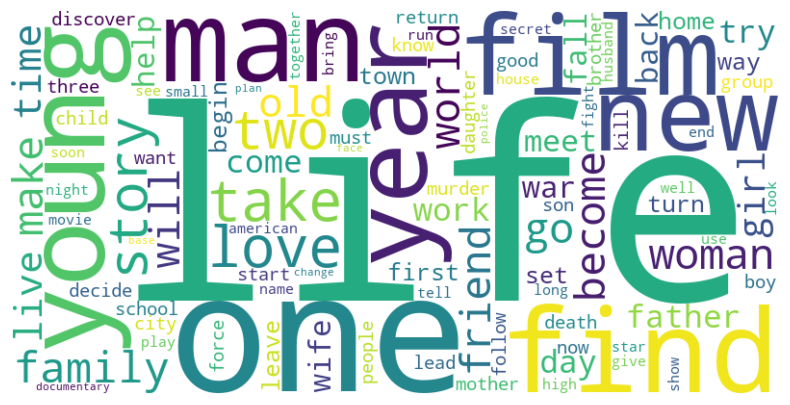

In [ ]:
wordcloud_params = {
    'width': 800,
    'height': 400,
    'background_color': 'white', 
    'max_words': 100,
    'collocations': False,
}
wordcloud = WordCloud(**wordcloud_params).generate(overviews_str)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### User input

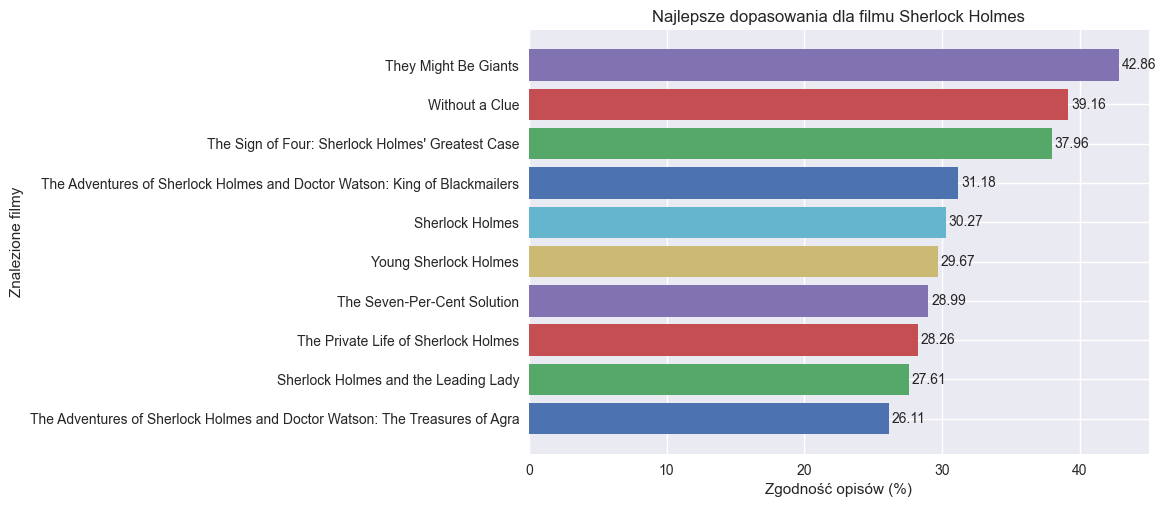

Do widzenia.


In [10]:
def run() -> None:
    while True:
        command = input('Znajdź film: ')
        match command.split():
            case ['quit', *items]:
                print('Do widzenia.')
                break
            case [*items]:
                title = ' '.join(items)
                top_matches = find_similar(title=title)
                if top_matches:
                    create_chart(matches=top_matches, title=title, savetofile=True)
                else:
                    suggest_titles(title=title)

run()

<hr style="border-top: 2px solid white">

<style>
    * {
      font-family: 'Consolas', monospace;
    }
    thead {
        background-color: #2596be;
    }
    tr:nth-child(even) {
      background-color: rgb(37, 150, 190);
    }
</style>